In [1]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
import pandas as pd
import numpy as np


/Volumes/D/AI/TVSeriesAnalysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/saivenkatreddykopparthi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

This applies only if the python version is 3.13
The above code leads to SLS Certificate error if we don't install the certificates.
- Open cmd and run the following command
    - bash '/Applications/Python 3.13/Install Certificates.command'
    - https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
- Now restart the kernal.


## Load Model

In [3]:
model_name = 'facebook/bart-large-mnli'
device = 0 if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
def load_model(device):
    theme_classifier = pipeline(
        'zero-shot-classification',
        model=model_name,
        device=device
    )

    return theme_classifier

In [46]:
theme_classifier = load_model(device)

Device set to use cpu


In [47]:
theme_list = ['friendship', 'hope', 'sacrifice', 'battle', 'self development', 'fight', 'war']

In [48]:
theme_classifier(
    'I gave him a right hook then a left jab',
    theme_list,
    multi_lavel=True
)

{'sequence': 'I gave him a right hook then a left jab',
 'labels': ['fight',
  'battle',
  'self development',
  'sacrifice',
  'war',
  'hope',
  'friendship'],
 'scores': [0.7275273203849792,
  0.15454179048538208,
  0.038549941033124924,
  0.027483636513352394,
  0.027198532596230507,
  0.019583700224757195,
  0.00511507410556078]}

## Load Data

In [49]:
import glob

In [50]:
files = glob.glob('../data/Subtitles/*.ass')

In [51]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    lines = lines[27:]
    lines = [",".join(line.split(',')[9:]) for line in lines]


In [52]:
lines[:2]

['We are Fighting Dreamers aiming high\n',
 "Fighting Dreamers\\Ndon't care what people think about them\n"]

In [53]:
lines = [line.replace('\\N', ' ') for line in lines]

In [54]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob.glob(dataset_path + '/*.ass')
    scripts = []
    episode_num = []
    for path in subtitles_paths:

        #Read lines
        with open(path, 'r') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines = [",".join(line.split(',')[9:]) for line in lines]
        
        lines = [line.replace('\\N', ' ') for line in lines]

        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)
    
    return pd.DataFrame.from_dict({"episode": episode_num, 'script':scripts})

In [55]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)
df.head()

,episode,script
0,94,We are Fighting Dreamers aiming high\n Fightin...
1,80,We are Fighting Dreamers aiming high\n Fightin...
2,32,"Press down hard on the gas\n That’s right, the..."
3,185,"Rock away your existence,\n Shouting that you ..."
4,191,"Rock away your existence,\n Shouting that you ..."


In [56]:
df[df['episode'] == 2]

,episode,script
48,2,"C'mon!\n Running like a fugitive,\n Being chas..."


## Run Model

In [57]:
script = df.iloc[0]['script']

In [58]:
script

'We are Fighting Dreamers aiming high\n Fighting Dreamers don\'t care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive!\n Right here right now (Burn)\n Down a difficult road filled with endless struggles\n Where do you think you are going following someone else\'s map?\n An insightful crow comes along to tear up the map\n Now open your eyes and take a look at the truth (Yeah!)\n There\'s nothing to lose, so let\'s GO!!!\n We are Fighting Dreamers aiming high\n Fighting Dreamers don\'t care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive!\n Right here right now (Burn) We\'re gonna do it and do our best!\n Right here right now (Bang) Hit it straight like a line drive!\n Right here right now (Burn) We\'re gonna do it and do our best! BANG!\n My bod

In [59]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

["We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh!",
 'Just go my way\n Right here right now (Bang) Hit it straight like a line drive!',
 "Right here right now (Burn)\n Down a difficult road filled with endless struggles\n Where do you think you are going following someone else's map?"]

In [60]:
# Batch sentences
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index: index + sentence_batch_size])
    script_batches.append(sent)

In [61]:
script_batches[:2]

["We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn)\n Down a difficult road filled with endless struggles\n Where do you think you are going following someone else's map? An insightful crow comes along to tear up the map\n Now open your eyes and take a look at the truth (Yeah!) There's nothing to lose, so let's GO!!! We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn) We're gonna do it and do our best! Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn) We're gonna do it and do our best! BANG! My body movements have final

In [62]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label = True
)

In [63]:
theme_output

[{'sequence': "We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn)\n Down a difficult road filled with endless struggles\n Where do you think you are going following someone else's map? An insightful crow comes along to tear up the map\n Now open your eyes and take a look at the truth (Yeah!) There's nothing to lose, so let's GO!!! We are Fighting Dreamers aiming high\n Fighting Dreamers don't care what people think about them\n Fighting Dreamers follow what they believe\n Oli Oli Oli Oh! Just go my way\n Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn) We're gonna do it and do our best! Right here right now (Bang) Hit it straight like a line drive! Right here right now (Burn) We're gonna do it and do our best! BANG! My body movemen

In [64]:
# Wrangle output
# battle: [0.3234, 0.6544]

themes = {}
for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

In [65]:
themes = {key : np.mean(np.array(value)) for key, value in themes.items()}

In [66]:
themes

{'battle': np.float64(0.9633688628673553),
 'fight': np.float64(0.9604405760765076),
 'self development': np.float64(0.9140430986881256),
 'war': np.float64(0.9512995481491089),
 'sacrifice': np.float64(0.9146701097488403),
 'hope': np.float64(0.5141087472438812),
 'friendship': np.float64(0.37528447434306145)}

In [67]:
themes

{'battle': np.float64(0.9633688628673553),
 'fight': np.float64(0.9604405760765076),
 'self development': np.float64(0.9140430986881256),
 'war': np.float64(0.9512995481491089),
 'sacrifice': np.float64(0.9146701097488403),
 'hope': np.float64(0.5141087472438812),
 'friendship': np.float64(0.37528447434306145)}

In [68]:
# putting everything in one big function

def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    #Batch sentence
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index: index + sentence_batch_size])
        script_batches.append(sent)

    #Run model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label = True
    )

    # Wrangle output
    # battle: [0.3234, 0.6544]

    themes = {}
    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)
    
    # get mean of scores
    themes = {key : np.mean(np.array(value)) for key, value in themes.items()}
    
    return themes

In [69]:
df = df.head(2)

df

,episode,script
0,94,We are Fighting Dreamers aiming high\n Fightin...
1,80,We are Fighting Dreamers aiming high\n Fightin...


In [70]:
output_themes = df['script'].apply(get_themes_inference)

In [71]:
output_themes

0    {'battle': 0.9633688628673553, 'fight': 0.9604...
1    {'battle': 0.9364225268363953, 'sacrifice': 0....
Name: script, dtype: object

In [72]:
theme_df = pd.DataFrame(output_themes.tolist())

In [73]:
theme_df

,battle,fight,self development,war,sacrifice,hope,friendship
0,0.963369,0.960441,0.914043,0.951300,0.914670,0.514109,0.375284
1,0.936423,0.791068,0.696007,0.863606,0.751554,0.385099,0.311896


In [74]:
df[theme_df.columns] = theme_df
df

,episode,script,battle,fight,self development,war,sacrifice,hope,friendship
0,94,We are Fighting Dreamers aiming high\n Fightin...,0.963369,0.960441,0.914043,0.951300,0.914670,0.514109,0.375284
1,80,We are Fighting Dreamers aiming high\n Fightin...,0.936423,0.791068,0.696007,0.863606,0.751554,0.385099,0.311896


# Visualize output

In [75]:
theme_output = df.drop(['episode', 'script'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,battle,1.899791
1,fight,1.751508
2,self development,1.610050
3,war,1.814906
4,sacrifice,1.666224
5,hope,0.899208
6,friendship,0.687181


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

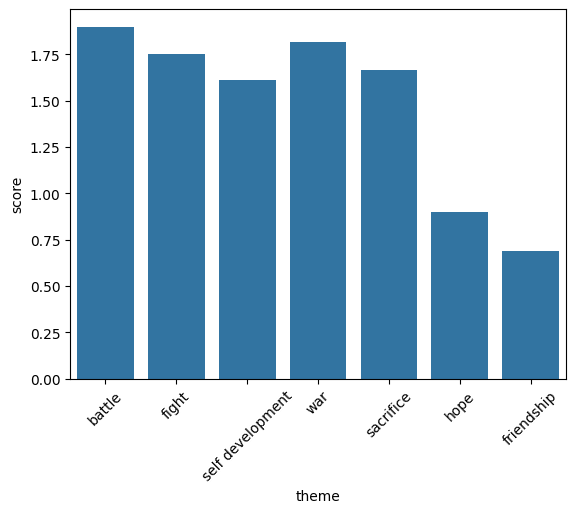

In [77]:
sns.barplot(data = theme_output, x='theme', y='score')
plt.xticks(rotation=45)
plt.show()